<a href="https://colab.research.google.com/github/DvAzevedo/Hybrid_Recommendation_System/blob/main/cf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Collaborative Filtering
import pandas as pd, numpy as np, math, random
from collections import defaultdict
from functools import lru_cache
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
drive.mount('/content/drive')

In [ ]:
def load_user_ratings(path: str):
    # Lê o ratings.csv e retorna um dicionario dos usuário e as notas, um conjunto com todos os titulos e um conjunto com todos os nomes(ids)
       # user_ratings : dict[user] -> {titulo: nota}
       # all_items    : set de todos os títulos
       # names        : set com todos os ids de usuário

    df = pd.read_csv(path)
    df = df.rename(columns={'user': 'userId', 'Titulo': 'title'})
    names      = set(df['userId'])
    all_titles = set(df['title'])

    user_ratings = {
        user: dict(zip(grp['title'], grp['rating']))
        for user, grp in df.groupby('userId')
    }
    return user_ratings, all_titles, names


def pearson(u1: dict[str, float], u2: dict[str, float]) -> float:
    #Correlação de Pearson entre os vetores de classificação de dois usuários.
    common = set(u1) & set(u2)
    if not common:
        return 0.0

    v1, v2 = np.array([u1[i] for i in common]), np.array([u2[i] for i in common])
    num = ((v1 - v1.mean()) * (v2 - v2.mean())).sum()
    den = math.sqrt(((v1 - v1.mean())**2).sum() * ((v2 - v2.mean())**2).sum())
    return num / den if den else 0.0


def neighbours(user_id: int,
               ratings: dict[int, dict[str, float]],
               k: int = 50,
               thresh: float = 0.0):
    #Retorna até k vizinhos cujo coeficiente de Pearson > thresh.
    sims = [(pearson(ratings[user_id], ratings[v]), v)
            for v in ratings if v != user_id]
    sims = [(s, v) for s, v in sims if s > thresh]
    return sorted(sims, reverse=True)[:k]


def predict(user_id: int,
            item: str,
            ratings: dict[int, dict[str, float]],
            neigh: list[tuple[float, int]],
            min_n: int = 3) -> float | None:
    #Prediz a nota que `user_id` daria a `item` usando vizinhos em `neigh`.
    votes = [(s, ratings[v][item]) for s, v in neigh if item in ratings[v]]
    if len(votes) < min_n:
        return None
    num = sum(s * r for s, r in votes)
    den = sum(abs(s) for s, _ in votes)
    return num / den if den else None


def recommend(user_id: int,
              ratings: dict[int, dict[str, float]],
              all_items: set[str],
              k: int = 50,
              sim_thresh: float = 0.0,
              min_neighbors: int = 3,
              top_n: int = 20):
    #Gera até `top_n` recomendações para `user_id`.
    already_rated = set(ratings[user_id])
    candidates    = all_items - already_rated

    neigh = neighbours(user_id, ratings, k=k, thresh=sim_thresh)

    recs = []
    for item in candidates:
        score = predict(user_id, item, ratings, neigh, min_n=min_neighbors)
        if score is not None:
            recs.append((item, score))

    recs.sort(key=lambda x: x[1], reverse=True)
    return recs[:top_n]


In [ ]:
def main():
    DATA_PATH        = '/content/drive/MyDrive/SemanticRec/Data/ratings_clean.csv'
    K                = 100                  # nº máximo de vizinhos
    SIM_THRESH       = 0.0                  # limiar de similaridade mínima
    MIN_NEIGHBORS    = 5                    # min. vizinhos que classificaram o item
    TOP_N            = 20                   # nº de recomendações a exibir

    #Carregar dados
    print("Carregando dados ...")
    user_ratings, all_items, names = load_user_ratings(DATA_PATH)

    # Interação com o usuário
    while True:
        entrada = input("Digite o id numérico do usuário: ").strip()
        if entrada.isdigit():
            user_id = int(entrada)
            if user_id in names:
                break
        print("Usuário não encontrado, tente novamente.\n")

    # Gerar recomendações
    recs = recommend(
        user_id,
        user_ratings,
        all_items,
        k=K,
        sim_thresh=SIM_THRESH,
        min_neighbors=MIN_NEIGHBORS,
        top_n=TOP_N
    )

    # Mostrar recomendações
    if recs:
        print(f"\nTop {len(recs)} recomendações para o usuário {user_id}:")
        for title, score in recs:
            print(f"   {title:<60} -> {score:5.2f}")
    else:
        print("Não foi possível gerar recomendações com os parâmetros atuais.")

if __name__ == "__main__":
    main()

Carregando dados ...
Digite o id numérico do usuário: 1

Top 20 recomendações para o usuário 1:
   Wallace & Gromit: The Wrong Trousers                         ->  4.92
   The Departed                                                 ->  4.81
   Postman, The (Postino, Il)                                   ->  4.74
   The Shawshank Redemption                                     ->  4.73
   To Kill a Mockingbird                                        ->  4.68
   Adaptation                                                   ->  4.66
   Life Is Beautiful (La Vita è bella)                          ->  4.65
   Cinema Paradiso (Nuovo cinema Paradiso)                      ->  4.64
   Spirited Away (Sen to Chihiro no kamikakushi)                ->  4.63
   Little Miss Sunshine                                         ->  4.62
   Raising Arizona                                              ->  4.62
   Peter Pan                                                    ->  4.61
   The Godfather            

In [ ]:

# K–fold cross-validation

import random
import math
from collections import defaultdict
from statistics import mean

# Métricas
def precision_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    return len(set(recommended_k) & set(relevant)) / k if k else 0.0

def recall_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    return len(set(recommended_k) & set(relevant)) / len(relevant) if relevant else 0.0

def f1_at_k(prec, rec):
    return 2 * prec * rec / (prec + rec) if (prec + rec) else 0.0

def ndcg_at_k(recommended, relevant, k):
    dcg = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            dcg += 1 / math.log2(i + 2)
    ideal_dcg = sum(1 / math.log2(i + 2) for i in range(min(len(relevant), k)))
    return dcg / ideal_dcg if ideal_dcg else 0.0


# Utils
_similarity_cache = {}
def pearson_cached(u1, u2, ratings):
    key = tuple(sorted((u1, u2)))
    if key not in _similarity_cache:
        _similarity_cache[key] = pearson(ratings[u1], ratings[u2])
    return _similarity_cache[key]


def top_k_users(user_id, ratings, k=100, sim_thresh=0.0):
    #Retorna até k usuários parecidos com user_id.
    sims = []
    for other in ratings:
        if other == user_id:
            continue
        s = pearson_cached(user_id, other, ratings)
        if s > sim_thresh:
            sims.append((s, other))
    sims.sort(reverse=True)
    return sims[:k]


# Cross-validation
def kfold_evaluate(ratings: dict[int, dict[str, float]],
                   all_items: set[str],
                   n_folds: int      = 10,
                   k_neigh: int      = 100,
                   sim_thresh: float = 0.0,
                   min_items_user: int = 6,
                   top_n: int          = 10,
                   rel_threshold: float = 4.0):
    """
    Avalia o sistema de recomendação via k-fold.
    Divide em folds sobre usuários.
    Para cada usuário de teste: 50% dos itens como conhecidos (vão para o treino) e 50% como desconhecidos (testes).
    É calculado MAE / RMSE das predições e métricas de top-N.
    """
    users = list(ratings)
    random.shuffle(users)
    fold_size = max(1, len(users) // n_folds)

    maes, rmses = [], []
    precisions, recalls, f1s, ndcgs = [], [], [], []

    for f in range(n_folds):
        _similarity_cache.clear()                 # limpa cache a cada fold
        start, end = f * fold_size, (f + 1) * fold_size
        test_users = set(users[start:end])
        train_users = set(users) - test_users

        train_ratings = {u: ratings[u].copy() for u in train_users}

        for user in test_users:
            full_items = list(ratings[user].items())
            if len(full_items) < min_items_user:
                continue

            random.shuffle(full_items)
            split = len(full_items) // 2
            known   = dict(full_items[:split])
            unknown = dict(full_items[split:])

            # adiciona parte conhecida ao treino
            train_ratings[user] = known

            # gera recomendações apenas para itens "unknown"
            candidate_items = list(unknown.keys())
            neigh = top_k_users(user, train_ratings, k=k_neigh, sim_thresh=sim_thresh)
            if not neigh:
                continue

            preds = []
            for item in candidate_items:
                votes = [(sim, train_ratings[v][item])
                         for sim, v in neigh if item in train_ratings[v]]
                if len(votes) < 3:                        # Pelo menos x vizinhos (nesse caso escolhi 3 como o mínimo)
                    continue
                num = sum(sim * r for sim, r in votes)
                den = sum(abs(sim) for sim, _ in votes)
                if den:
                    preds.append((item, num / den))

            if not preds:
                continue

            preds.sort(key=lambda x: x[1], reverse=True)
            top_preds = preds[:top_n]

            # Erros de predição
            for item, p in top_preds:
                if item in unknown:
                    err = abs(unknown[item] - p)
                    maes.append(err)
                    rmses.append(err ** 2)

            # Métricas top-N
            relevant = [i for i, r in unknown.items() if r >= rel_threshold]
            recommended = [i for i, _ in top_preds]
            if relevant:
                prec = precision_at_k(recommended, relevant, top_n)
                rec  = recall_at_k(recommended, relevant, top_n)
                precisions.append(prec)
                recalls.append(rec)
                f1s.append(f1_at_k(prec, rec))
                ndcgs.append(ndcg_at_k(recommended, relevant, top_n))

    results = {
        "MAE"        : mean(maes) if maes else None,
        "RMSE"       : math.sqrt(mean(rmses)) if rmses else None,
        "Precision@N": mean(precisions) if precisions else None,
        "Recall@N"   : mean(recalls)    if recalls    else None,
        "F1@N"       : mean(f1s)        if f1s        else None,
        "NDCG@N"     : mean(ndcgs)      if ndcgs      else None,
        "Usuários avaliados": len(precisions)
    }
    return results



user_ratings, all_items, _ = load_user_ratings("/content/drive/MyDrive/SemanticRec/Data/ratings_clean.csv")

cv_metrics = kfold_evaluate(
    ratings      = user_ratings,
    all_items    = all_items,
    n_folds      = 10,
    k_neigh      = 100,
    sim_thresh   = 0.0,
    min_items_user = 6,
    top_n        = 10,
    rel_threshold = 4.0      # Define o mínimo para o vizinho ser relevante
)

print(cv_metrics)


{'MAE': np.float64(0.7266535124117577), 'RMSE': 0.9535745064141471, 'Precision@N': 0.7089256198347107, 'Recall@N': 0.41693863990667324, 'F1@N': 0.4431421288819472, 'NDCG@N': 0.7620384173587312, 'Usuários avaliados': 605}


<Figure size 600x400 with 0 Axes>

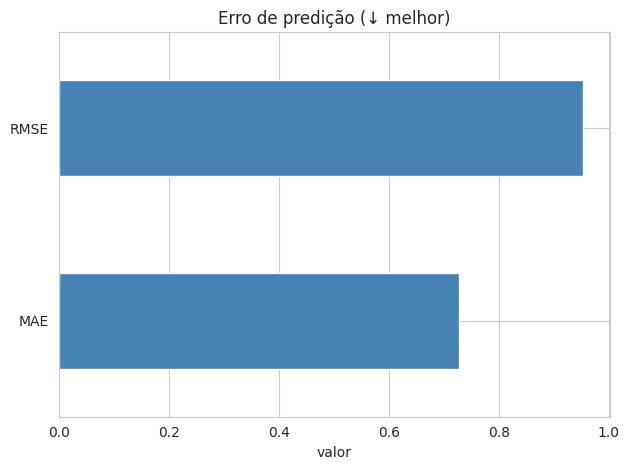

<Figure size 600x400 with 0 Axes>

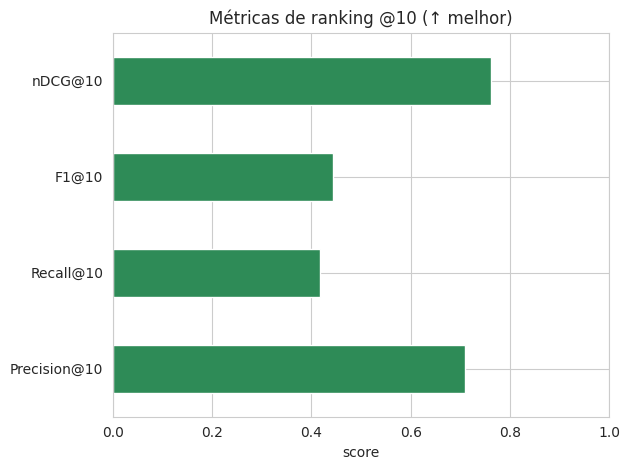

In [ ]:
top_n = 10
sns.set_style("whitegrid")

df_metrics = pd.DataFrame([cv_metrics])

rename_map = {
    "Precision@N": f"Precision@{top_n}",
    "Recall@N"   : f"Recall@{top_n}",
    "F1@N"       : f"F1@{top_n}",
    "NDCG@N"     : f"nDCG@{top_n}",
}
df_metrics.rename(columns=rename_map, inplace=True)


plt.figure(figsize=(6, 4))


df_metrics[["MAE", "RMSE"]].T.plot(
    kind="barh", color="steelblue", legend=False)

plt.title("Erro de predição (↓ melhor)")
plt.xlabel("valor")
plt.ylabel("")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))

rank_cols = [f"Precision@{top_n}", f"Recall@{top_n}", f"F1@{top_n}", f"nDCG@{top_n}"]
df_metrics[rank_cols].T.plot(
    kind="barh", color="seagreen", legend=False)

plt.title(f"Métricas de ranking @{top_n} (↑ melhor)")
plt.xlabel("score")
plt.xlim(0, 1)
plt.ylabel("")
plt.tight_layout()
plt.show()
